In [120]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from scipy import interp
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-'
       'learning-databases/breast-cancer-wisconsin/wdbc.data',
       header=None)

In [11]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

In [12]:
le = LabelEncoder()
y = le.fit_transform(y)

In [15]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

In [17]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression())])

In [18]:
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [20]:
print("Test Accuracy: {}".format(pipe_lr.score(X_test, y_test)))

Test Accuracy: 0.9649122807017544


# K-fold Cross validation

In [22]:
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train,
                        cv=10, n_jobs=-1)

In [23]:
print('CV accuracy scores: {}'.format(scores))

CV accuracy scores: [ 0.91304348  0.95652174  0.93478261  0.95652174  0.97826087  0.95652174
  1.          0.93333333  0.95454545  0.95454545]


# Learning curve (model perf as function of data sizes)

In [35]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('lr', LogisticRegression())])
train_sizes, train_scores, test_scores = \
    learning_curve(pipe_lr, X_train, y_train,
                   train_sizes=np.linspace(0.1, 1, 10),
                   cv=5, n_jobs=-1)

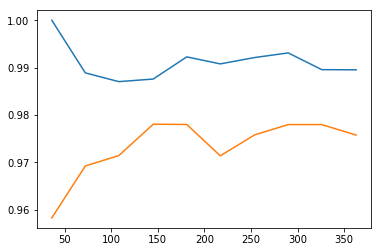

In [39]:
plt.plot(train_sizes, np.mean(train_scores, axis=1))
plt.plot(train_sizes, np.mean(test_scores, axis=1))


# Validation curve (model perf as function of hyperparameters)

In [50]:
train_scores, test_scores = \
    validation_curve(pipe_lr, X_train, y_train,
                     param_name='lr__C',
                     param_range=[0.001, 0.01, 0.1, 1, 10, 100],
                     cv=10)

In [55]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

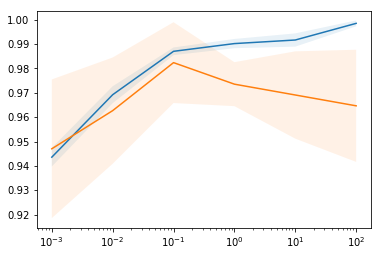

In [62]:
param_range = [0.001, 0.01, 0.1, 1, 10, 100]
plt.plot(param_range, train_mean)
plt.plot(param_range, test_mean)
plt.fill_between(param_range, 
                 train_mean - train_std, train_mean + train_std,
                 alpha=0.1)
plt.fill_between(param_range, 
                 test_mean - test_std, test_mean + test_std,
                 alpha=0.1)
plt.xscale('log')

In [58]:
train_mean

array([ 0.94359161,  0.96923363,  0.98705585,  0.99023017,  0.99169776,
        0.99853479])

# Modeling tuning via grid search

In [74]:
pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])
param_range = np.geomspace(0.0001, 1000, num=8)

In [75]:
param_grid = [{'clf__C': param_range, 
               'clf__kernel': ['linear']},
              {'clf__C': param_range, 
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs = GridSearchCV(pipe_svc, param_grid=param_grid,
                  scoring='accuracy', cv=10, n_jobs=-1)

In [76]:
gs = gs.fit(X_train, y_train)

In [77]:
print(gs.best_score_)

0.9758241758241758


In [78]:
print(gs.best_params_)

{'clf__C': 10.0, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


In [79]:
clf = gs.best_estimator_

In [81]:
clf = clf.fit(X_train, y_train)
print('Test accuracy: {}'.format(clf.score(X_test, y_test)))

Test accuracy: 0.9736842105263158


# Nested cross-validation

In [82]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                  cv=10, n_jobs=-1)

In [83]:
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)

In [89]:
np.mean(scores)

0.97192766448634083

In [92]:
print('CV accuracy: {:.3f} +/- {:.3f}'.format(np.mean(scores), np.std(scores)))

CV accuracy: 0.972 +/- 0.012


# Metrics

In [94]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

In [95]:
confusion_matrix(y_test, y_pred)

array([[69,  0],
       [ 2, 43]])

In [97]:
print('Precision score {}'.format(precision_score(y_test, y_pred)))

Precision score 1.0


In [98]:
print('Recall {}'.format(recall_score(y_test, y_pred)))

Recall 0.9555555555555556


In [99]:
print('F1 score {}'.format(f1_score(y_test, y_pred)))

F1 score 0.9772727272727273


In [101]:
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(pipe_svc, param_grid,
                 scoring=scorer, cv=10)

# ROC

In [105]:
cv = StratifiedKFold(n_splits=3, random_state=1)

In [107]:
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [108]:
probas = pipe_lr.predict_proba(X_test)

In [125]:
fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

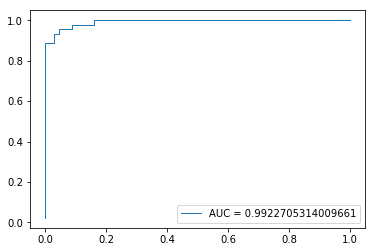

In [126]:
plt.plot(fpr, tpr, lw=1, label='AUC = {}'.format(roc_auc))
plt.legend(loc="lower right")

In [142]:
fpr, tpr, thresholds = roc_curve(y_test, 
                                 pipe_lr.predict_proba(X_test)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)
print(roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:,1]))

0.992270531401
0.992270531401


In [128]:
auc(fpr, tpr)

0.9922705314009661

In [138]:
pipe_lr.predict(X_test)

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0])